# SARS-CoV-2/COVID-19 ABO/Rh blood group analysis

Michael Zietz, Nicholas Tatonetti

Updated in response to reviewer comments

In [1]:
options(readr.num_columns = 0, repr.matrix.max.cols = 50)

library(broom)
suppressMessages(library(cowplot))
suppressMessages(library(tidyverse))

library(grid)
suppressMessages(library(gridExtra))
suppressMessages(library(meta))

In [2]:
con <- DBI::dbConnect(
    RMariaDB::MariaDB(),
    host = "localhost",
    user = "mnz2108",
    dbname = "clinical_merge_v5_240919",
    password = read_file('../mysql_password.txt') %>% str_squish
)

date = '2020-06-15'
hash = '66ec50743325ded678ab71acb1794a7f25bf8a85'

res <- DBI::dbSendQuery(con, str_glue('SET @date = DATE("{date}")'))
res <- DBI::dbSendQuery(con, str_glue('SET @version_hash = "{hash}"'))

Warning message in result_create(conn@ptr, statement, is_statement):
“Cancelling previous query”

In [3]:
sql_to_tibble <- function(sql_code, .con = con) {
    sql_code %>%
        str_glue %>%
        sql %>%
        tbl(src = .con) %>%
        as_tibble
}

## 1. Collect data

### 1.1. NYP/CUIMC data for SARS-CoV-2 tested individuals

This analysis uses a `.sql` script to build the table used for analysis here (`user_mnz2108.abo_covid_analysis_wide`). This script must be run to create the appropriate table before this notebook can run.

In [4]:
analysis_df <- '
    SELECT *
    FROM user_mnz2108.abo_covid_analysis_wide
    WHERE date_retrieved = @date AND version_hash = @version_hash
    ' %>%
    sql_to_tibble

In [5]:
analysis_df %>% colnames

# These numbers should be the same (one row per person)
analysis_df %>% summarize(n(), n_distinct(pat_mrn_id))

# Check that no columns have NAs
analysis_df %>% map(~sum(is.na(.))) %>% keep(. > 0)

[1] "pat_mrn_id"                          
 [2] "male_sex"                            
 [3] "age"                                 
 [4] "ethnicity"                           
 [5] "race"                                
 [6] "abo"                                 
 [7] "rh"                                  
 [8] "risk_factor_cardiovascular_disorders"
 [9] "risk_factor_diabetes_mellitus"       
[10] "risk_factor_hypertension"            
[11] "risk_factor_obesity"                 
[12] "risk_factor_respiratory_disorders"   
[13] "cov_pos"                             
[14] "intubated"                           
[15] "died"                                
[16] "date_retrieved"                      
[17] "version_hash"

n(),n_distinct(pat_mrn_id)
<int>,<int>
7770,7770


named list()

### 1.2. Population blood group frequencies for meta-analysis

#### 1.2.1. NYP/CUIMC general population

Individuals not tested for SARS-CoV-2 infection.

In [6]:
general_population_blood_groups_df <- '
    SELECT abo, rh, n
    FROM user_mnz2108.blood_groups_general_population
    WHERE date_retrieved = @date
    ' %>%
    sql_to_tibble %>%
    mutate(n = n %>% as.double)

In [7]:
nyp_meta_counts <- analysis_df %>% 
    group_by(abo) %>% 
    summarize(patients = sum(cov_pos), .groups = 'drop') %>%
    inner_join(
        general_population_blood_groups_df %>% 
            group_by(abo) %>% 
            summarize(controls = sum(n), .groups = 'drop'),
        by = 'abo'
    ) %>%
    rename(blood_group = abo) %>%
    mutate(site = 'NYP/CUIMC')

#### 1.2.2 Zhao et al. data from China

https://doi.org/10.1101/2020.03.11.20031096

In [8]:
zhao_counts_df <- data.frame(
        blood_group = c('A', 'B', 'AB', 'O'),
        wuhan_controls = c(1188, 920, 336, 1250),
        wuhan_jinyintan_pts = c(670, 469, 178, 458),
        wuhan_jinyintan_died = c(85, 50, 19, 52),
        wuhan_renmin_pts = c(45, 25, 15, 28),
        shenzhen_controls = c(6728, 5880, 1712, 9066),
        shenzhen_pts = c(82, 83, 39, 81)
    ) %>%
    mutate(wuhan_controls_copy = wuhan_controls) %>%
    select(-wuhan_jinyintan_died) %>%
    nest(
        'Wuhan Jinyintan' = c(wuhan_jinyintan_pts, wuhan_controls),
        'Wuhan Renmin' = c(wuhan_renmin_pts, wuhan_controls_copy),
        'Shenzhen' = c(shenzhen_pts, shenzhen_controls)
    ) %>%
    pivot_longer(c('Wuhan Jinyintan', 'Wuhan Renmin', 'Shenzhen'), names_to = 'site', 
                 values_to = 'pts_controls') %>%
    mutate(pts_controls = pts_controls %>% map(~set_names(., c('patients', 'controls'))))  %>%
    unnest(pts_controls)

#### 1.2.3 UK Biobank data

Individuals tested for infection with genetic data available. Blood groups assigned using genetic data in the UK Biobank notebook.

In [9]:
ukb_counts_df <- read_tsv('../data/ukb_2020-05-07.tsv') %>% 
    mutate(site = 'UK Biobank') %>% 
    select(blood_group, site, patients = cov_pos, controls = general_pop)

#### 1.2.4 Combine meta-analysis data sources

In [10]:
meta_analysis_counts <- bind_rows(   
        nyp_meta_counts,
        zhao_counts_df, 
        ukb_counts_df
    )

## 2. Data prep

### 2.1. Normalize, add derived fields

In [11]:
# This was the table on which the analysis was done. It's basically a wide-format table, one
# row per individual, with all comorbidities, demographics, etc. in one table.

regression_df <- analysis_df %>%
    select(-date_retrieved, -version_hash) %>%
    mutate(
        age_normed = (age - mean(age)) / sd(age),
    
        abo_rh = str_c(abo, rh, sep = '_'),
    ) %>%
    relocate(abo_rh, .after = rh)

regression_df %>% colnames

# Check no NAs
regression_df %>% map(~sum(is.na(.))) %>% keep(. > 0)                                  

[1] "pat_mrn_id"                          
 [2] "male_sex"                            
 [3] "age"                                 
 [4] "ethnicity"                           
 [5] "race"                                
 [6] "abo"                                 
 [7] "rh"                                  
 [8] "abo_rh"                              
 [9] "risk_factor_cardiovascular_disorders"
[10] "risk_factor_diabetes_mellitus"       
[11] "risk_factor_hypertension"            
[12] "risk_factor_obesity"                 
[13] "risk_factor_respiratory_disorders"   
[14] "cov_pos"                             
[15] "intubated"                           
[16] "died"                                
[17] "age_normed"

named list()

## 3. Analysis

### 3.1. Tests for overall association

#### 3.1.1 Setup contingency tables

In [12]:
cuimc_contingency <- regression_df %>%
    pivot_longer(c(abo, rh, abo_rh), names_to = 'blood_group_type', 
                 values_to = 'blood_group') %>%
    mutate(
        cov_tested = 1,
        cov_neg = 1 - cov_pos,
        intubated_cov_pos = intubated * cov_pos, 
        died_cov_pos = died * cov_pos,
        not_intubated_cov_pos = cov_pos * (1 - intubated),
        alive_cov_pos = cov_pos * (1 - died),
    ) %>%

    group_by(blood_group_type, blood_group) %>%
    summarize(across(c(cov_pos, cov_neg, cov_tested, intubated, died, intubated_cov_pos, 
                       not_intubated_cov_pos, died_cov_pos, alive_cov_pos), sum), 
              .groups = 'drop') %>%
    
    inner_join(
        general_population_blood_groups_df %>%
            mutate(abo_rh = str_c(abo, rh, sep = '_')) %>%
            pivot_longer(c(abo, rh, abo_rh), names_to = 'blood_group_type', 
                         values_to = 'blood_group') %>%
            group_by(blood_group_type, blood_group) %>%
            summarize(n = sum(n), .groups = 'drop'),
        by = c('blood_group_type', 'blood_group')
    ) %>%
    rename('general_pop' = n) %>%
    filter(blood_group != 'AB_neg')

#### 3.1.2. Chi-squared tests

In [13]:
# Test for independence between ABO and Rh
abo_vs_rh_chisq_df <- regression_df %>%
    select(abo, rh) %>%
    table %>%
    as_tibble %>%
    group_by(rh) %>%
    mutate(count = str_glue('{abo}: {n} ({round(100 * n / sum(n), 1)}%)')) %>%
    summarize(count = paste(count, collapse = ', '), .groups = 'drop') %>%
    pivot_wider(names_from = rh, values_from = count) %>%
    rename(group_1 = neg, group_2 = pos) %>%
    bind_cols(
        regression_df %>%
            select(abo, rh) %>%
            table %>%
            chisq.test %>%
            tidy
    ) %>%
    mutate(test_id = 'Rh-neg vs Rh-pos', blood_group_type = 'ABO')

In [14]:
contingency_tests <- list(
    'COV+ vs COV-' = c('cov_pos', 'cov_neg'),
    'COV+ vs general population' = c('cov_pos', 'general_pop'),
    'COV+/Intubated vs COV+/Not intubated' = c('intubated_cov_pos', 'not_intubated_cov_pos'),
    'COV+/Intubated vs COV+' = c('intubated_cov_pos', 'cov_pos'),
    'COV+/Died vs COV+/Alive' = c('died_cov_pos', 'alive_cov_pos'),
    'COV+/Died vs COV+' = c('died_cov_pos', 'cov_pos'),
    'SARS-CoV-2 tested vs general population' = c('cov_tested', 'general_pop')
)

In [15]:
chi_squared_df <- cuimc_contingency %>%
    mutate(test = list(contingency_tests)) %>%
    unnest_longer(test) %>%
    nest(data = c(-blood_group_type, -test_id, -test)) %>%
    mutate(
        # Keep only the columns in data needed for the relevant test
        data = map2(data, test, ~select(.x, 'blood_group', all_of(.y))),
        # Perform Chi-squared test
        chisq = data %>% map(~select(., -'blood_group')) %>% map(chisq.test) %>% map(tidy),
        nice_counts = data %>% 
            map(~set_names(.x, c('blood_group', 'group_1', 'group_2')) %>%
                mutate(across(-blood_group, 
                              ~str_glue('{blood_group}: {.} ({round(100 * . / sum(.), 1)}%)'))) %>%
                summarize(across(-blood_group, ~paste(., collapse = ', ')))
            ),
    ) %>%
    select(-data, -test) %>%
    unnest(c(nice_counts, chisq)) %>%
    bind_rows(abo_vs_rh_chisq_df) %>%
    relocate(c(group_1, group_2), .after = test_id)

### 3.2. Tests for individual blood group associations

Univariate and multivariate logistic regressions

In [16]:
# Formulae for univariate and multivariate regressions
# (outcome included later)
formulae = list(
    'univariate' = ' ~ had_blood_group',
    'multivariate' = ' ~
        age_normed + male_sex + 
        ethnicity_hs + ethnicity_other + ethnicity_missing + 
        race_asian + race_black_aa + race_other + race_missing + 

        risk_factor_cardiovascular_disorders + 
        risk_factor_diabetes_mellitus + 
        risk_factor_hypertension + 
        risk_factor_obesity + 
        risk_factor_respiratory_disorders + 

        had_blood_group'
)

# Criteria for inclusion in the comparison for each outcome
strata <- list(
    'cov_pos' = 'T',
    'intubated' = 'cov_pos == 1',
    'died' = 'cov_pos == 1'
)

In [17]:
individual_blood_group_associations_df <- regression_df %>%
    # Define and enforce cohort entry conditions for each outcome
    mutate(stratum = list(strata)) %>%
    unnest_longer(stratum, indices_to = 'outcome') %>%
    rowwise() %>%
    filter(eval(rlang::parse_expr(stratum))) %>%
    ungroup %>%
    # Make blood group, race, ethnicity explicit dummy variables
    recipes::recipe() %>%
    recipes::step_dummy(abo, rh, abo_rh, race, ethnicity, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    pivot_longer(c(starts_with('abo_'), starts_with('rh_')), names_to = 'blood_group', 
                 values_to = 'had_blood_group') %>%
    mutate(
        blood_group_type = blood_group %>% str_extract('abo_rh|abo|rh'),
        blood_group = blood_group %>% str_replace_all(c('abo_rh_' = '', 'abo_' = '', 'rh_' = ''))
    ) %>%
    # Analysis
    nest(data = c(-outcome, -blood_group_type, -blood_group)) %>%
    mutate(formula = list(formulae)) %>%
    unnest_longer(formula) %>%
    mutate(
        formula = str_c(outcome, formula),
        reg = map2(formula, data, ~glm(as.formula(.x), data = .y, family = binomial())) %>% map(tidy)
    ) %>%
    select(-data, -formula) %>%
    unnest(reg)

### 3.3. Further multivariate analysis

#### 3.3.1. Blood group ~ RF

In [18]:
bg_rf_formula = '
    had_blood_group ~ 

    age_normed + male_sex +

    ethnicity_hs + ethnicity_other + ethnicity_missing +
    race_asian + race_black_aa + race_other + race_missing +

    risk_factor_cardiovascular_disorders + risk_factor_diabetes_mellitus + risk_factor_hypertension + 
    risk_factor_obesity + risk_factor_respiratory_disorders
    '

In [19]:
bg_rf_df <- regression_df %>% 
    # Make blood group, race, ethnicity explicit dummy variables
    recipes::recipe() %>%
    recipes::step_dummy(abo, rh, abo_rh, race, ethnicity, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    pivot_longer(c(starts_with('abo_'), starts_with('rh_')), names_to = 'blood_group', 
                 values_to = 'had_blood_group') %>%
    mutate(
        blood_group_type = blood_group %>% str_extract('abo_rh|abo|rh'),
        blood_group = blood_group %>% str_replace_all(c('abo_rh_' = '', 'abo_' = '', 'rh_' = ''))
    ) %>%
    # Analysis
    nest(data = c(-blood_group_type, -blood_group)) %>%
    mutate(reg = data %>% map(~glm(bg_rf_formula, data = ., family = binomial())) %>% map(tidy)) %>%
    select(-data) %>%
    unnest(reg)

#### 3.3.2. Model fits for groups of variables

Reference groups (typically most common group)

| Characteristic | Reference group |
| -------------- | --------------- |
| ABO            | O               |
| ABO/Rh         | O-positive      |
| Rh             | positive        |
| Race           | White   |
| Ethnicity      | Non-Hispanic |

From now on, "RF" means age, sex, race, ethnicity, comorbid "risk factors".

For this part of the analysis, I'm keeping the formatting separate from the statistics. I hope this will make reading the statistics code more clear.

In [20]:
# Risk factors
rf <- '
    age_normed + male_sex +

    ethnicity_hs + ethnicity_other + ethnicity_missing +
    race_asian + race_black_aa + race_other + race_missing +

    risk_factor_cardiovascular_disorders + risk_factor_diabetes_mellitus + risk_factor_hypertension + 
    risk_factor_obesity + risk_factor_respiratory_disorders
    '

# Logistic regressions to be run. Specifying explicitly to ensure that the reference group
#  is the one we want it to be (most common group).
formulae <- list(
        'null' = ' ~ 1',
        'Risk factors' = ' ~ {rf}',
        'ABO' = ' ~ abo_A + abo_B + abo_AB',
        'ABO + Risk factors' = ' ~ {rf} + abo_A + abo_B + abo_AB',
        'ABO/Rh' = ' ~ abo_rh_A_neg + abo_rh_A_pos + abo_rh_B_neg + abo_rh_B_pos + 
                       abo_rh_AB_pos + abo_rh_O_neg',
        'ABO/Rh + Risk factors' = ' ~ {rf} + abo_rh_A_neg + abo_rh_A_pos + abo_rh_B_neg + abo_rh_B_pos + 
                          abo_rh_AB_pos + abo_rh_O_neg',
        'Rh(D)' = ' ~ rh_neg',
        'Rh(D) + Risk factors' = ' ~ {rf} + rh_neg'
    ) %>%
    map(str_glue) %>%
    map(str_squish)

# Map from outcome to criteria for inclusion in the comparison for that outcome
strata <- list(
    'cov_pos' = 'T',
    'intubated' = 'cov_pos == 1',
    'died' = 'cov_pos == 1'
)

# Model fits to compare
comparisons <- list(
        'Risk factors vs Null' = c('Risk factors', 'null'),
        'ABO + Risk factors vs Risk factors' = c('ABO + Risk factors', 'Risk factors'),
        'ABO/Rh + Risk factors vs Risk factors' = c('ABO/Rh + Risk factors', 'Risk factors'),
        'Rh(D) + Risk factors vs Risk factors' = c('Rh(D) + Risk factors', 'Risk factors')
    ) %>% 
    map(~set_names(.x, 'group_1', 'group_2'))

In [21]:
model_fit_regressions_df <- regression_df %>% 
    # One hot encode blood groups
    recipes::recipe() %>%
    recipes::step_dummy(abo, rh, abo_rh, race, ethnicity, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    # Define and enforce cohort entry conditions for each outcome
    mutate(
        cov_tested = !is.na(cov_pos), 
        stratum = list(strata)
    ) %>%
    unnest_longer(stratum, indices_to = 'outcome') %>%
    rowwise() %>%
    filter(eval(rlang::parse_expr(stratum))) %>%
    ungroup %>%
    # Actual analyses
    nest(data = c(-outcome)) %>%
    mutate(formula = list(formulae)) %>%
    unnest_longer(formula) %>%
    mutate(
        formula = str_c(outcome, formula),
        reg = map2(formula, data, ~glm(as.formula(.x), data = .y, family = binomial()))
    ) %>%
    pivot_wider(names_from = formula_id, values_from = reg, id_cols = c(outcome, data)) %>%
    select(-data)

In [22]:
model_fits_df <- model_fit_regressions_df %>%
    # Filter to the appropriate comparison 
    mutate(comparison = list(comparisons)) %>%
    unnest_longer(comparison) %>%
    unnest_wider(comparison) %>%
    nest(data = c(-outcome, -group_1, -group_2, -comparison_id)) %>%
    mutate(data = pmap(list(data, group_1, group_2), select) %>% map(~set_names(.x, 'reg_1', 'reg_2'))) %>%
    unnest(data) %>%
    # Perform comparison
    mutate(anova = map2(reg_1, reg_2, ~anova(.x, object = .y, test = 'Chisq'))) %>%
    unnest(anova) %>%
    select(-reg_1, -reg_2, -group_1, -group_2) %>%
    filter(!is.na(Df))

### 3.4. Meta-analysis

In [23]:
# Helper functions for converting meta-analysis results into dataframes
augment.metabin <- function(metabin_result) {
    data.frame(
        site_name = metabin_result$studlab,
        OR = exp(metabin_result$TE),
        conf.low = exp(metabin_result$lower),
        conf.high = exp(metabin_result$upper),
        weight = metabin_result$w.random / sum(metabin_result$w.random)
    )
}

glance.metabin <- function(metabin_result) {
    data.frame(
        tau_2 = metabin_result$tau2,
        I_squared = metabin_result$I2,
        I_squared_CI_lower = metabin_result$lower.I2,
        I_squared_CI_upper = metabin_result$upper.I2,
        H = metabin_result$H,
        H_CI_lower = metabin_result$lower.H,
        H_CI_upper = metabin_result$upper.H,
        Q = metabin_result$Q,
        Q_df = metabin_result$df.Q,
        Q_p_value = metabin_result$pval.Q
    )
}

tidy.metabin <- function(metabin_result) {
    data.frame(
        OR = exp(metabin_result$TE.random),
        conf.low = exp(metabin_result$lower.random),
        conf.high = exp(metabin_result$upper.random),
        Z = metabin_result$zval.random,
        p.value = metabin_result$pval.random
    )
}

In [24]:
meta_analysis_df <- meta_analysis_counts %>%
    # Add counts for patients and controls of other blood groups at the same site
    group_by(site) %>%
    mutate(
        other_bg_patients = sum(patients) - patients, 
        other_bg_controls = sum(controls) - controls
    ) %>%
    ungroup %>%
    nest(data = c(-blood_group)) %>%
    mutate(
        meta = data %>% 
            map(~meta::metabin(
                event.e = patients, 
                n.e = patients + controls, 
                event.c = other_bg_patients, 
                n.c = other_bg_patients + other_bg_controls,
                studlab = site,
                data = .x,
                comb.random = T,
                comb.fixed = F,
                sm = 'OR'
            )),
        meta_site_weights = meta %>% map(augment),
        meta_overall = meta %>% map(tidy),
        meta_heterogeneity = meta %>% map(glance)
    ) %>%
    select(-data)

In [25]:
# Extract dataframe version of the meta-analysis results
meta_pooled_effects <- meta_analysis_df %>%
    select(blood_group, meta_overall) %>%
    unnest(meta_overall)

meta_site_weights <- meta_analysis_df %>%
    select(blood_group, meta_site_weights) %>%
    unnest(meta_site_weights)

meta_sites_heterogeneity <- meta_analysis_df %>%
    select(blood_group, meta_heterogeneity) %>%
    unnest(meta_heterogeneity)

### 3.5. Miscellaneous brief analyses

In [27]:
# Whether blood groups are equivalent between meta-analysis sites
meta_counts <- meta_analysis_counts %>%
    pivot_wider(id_cols = blood_group, names_from = site, values_from = controls) %>%
    select(-blood_group, 'Wuhan' = 'Wuhan Jinyintan', -'Wuhan Renmin')

list('Wuhan', 'Shenzhen', 'UK Biobank') %>%
    map(~chisq.test(meta_counts[c(.x, 'NYP/CUIMC')]) %>% tidy %>% mutate(site = .x)) %>%
    bind_rows() %>%
    mutate(
        log_p = dchisq(x = statistic, df = parameter, log = T),
        b = floor(log_p / log(10)),
        a = exp(log_p - b * log(10)),
        across(c(a, b), ~round(., 1)),
        formatted = str_glue('{a}e{b}')
    )

statistic,p.value,parameter,method,site,log_p,b,a,formatted
<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<glue>
580.6443,1.5825e-125,3,Pearson's Chi-squared test,Wuhan,-288.059,-126,7.9,7.9e-126
2036.2870,0.0000e+00,3,Pearson's Chi-squared test,Shenzhen,-1015.253,-441,1.2,1.2e-441
5289.8534,0.0000e+00,3,Pearson's Chi-squared test,UK Biobank,-2641.559,-1148,6.1,6.1e-1148


### 3.6. Race/ethnicity stratified analysis

In [28]:
# Formulae for univariate and multivariate regressions
# (outcome included later)
formulae = list(
    'univariate' = ' ~ had_blood_group',
    'multivariate' = ' ~
        age_normed + male_sex + 

        risk_factor_cardiovascular_disorders + 
        risk_factor_diabetes_mellitus + 
        risk_factor_hypertension + 
        risk_factor_obesity + 
        risk_factor_respiratory_disorders + 

        had_blood_group'
)

# Criteria for inclusion in the comparison for each outcome
strata <- list(
    'cov_pos' = 'T',
    'intubated' = 'cov_pos == 1',
    'died' = 'cov_pos == 1'
)

In [29]:
race_stratified_bg_vs_rest <- regression_df %>%
    # Define and enforce cohort entry conditions for each outcome
    mutate(stratum = list(strata)) %>%
    unnest_longer(stratum, indices_to = 'outcome') %>%
    rowwise() %>%
    filter(eval(rlang::parse_expr(stratum))) %>%
    ungroup %>%
    # Make blood group explicit dummy variables
    recipes::recipe() %>%
    recipes::step_dummy(abo, rh, abo_rh, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    pivot_longer(c(starts_with('abo_'), starts_with('rh_')), names_to = 'blood_group', 
                 values_to = 'had_blood_group') %>%
    pivot_longer(c(race, ethnicity), names_to = 'race_or_ethnicity', values_to = 'race_ethnicity') %>%
    unite('race_ethnicity', c(race_or_ethnicity, race_ethnicity), sep = '_') %>%
    mutate(
        blood_group_type = blood_group %>% str_extract('abo_rh|abo|rh'),
        blood_group = blood_group %>% str_replace_all(c('abo_rh_' = '', 'abo_' = '', 'rh_' = '')),
    ) %>%
    # Analysis
    nest(data = c(-outcome, -blood_group_type, -blood_group, -race_ethnicity)) %>%
    mutate(formula = list(formulae)) %>%
    unnest_longer(formula) %>%
    mutate(
        formula = str_c(outcome, formula),
        reg = map2(formula, data, ~glm(as.formula(.x), data = .y, family = binomial())) %>% map(tidy)
    ) %>%
    select(-data, -formula) %>%
    unnest(reg)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted 

## 4. Formatted outputs

In [30]:
characteristic_names <- c(
    'n' = 'N', 
    'age' = 'Median age (IQR)', 
    'male_sex' = 'Male sex (%)', 
    'race_asian' = 'Race - Asian (%)',
    'race_black_aa' = 'Race - Black/AA (%)',
    'race_white' = 'Race - White (%)',
    'race_other' = 'Race - Other (%)',
    'race_missing' = 'Race - Missing (%)',
    'ethnicity_hs' = 'Ethnicity - Hispanic (%)',
    'ethnicity_nonhs' = 'Ethnicity - Non-Hispanic (%)',
    'ethnicity_other' = 'Ethnicity - Other (%)',
    'ethnicity_missing' = 'Ethnicity - Missing (%)',

    'risk_factor_hypertension' = 'Hypertension (%)',
    'risk_factor_cardiovascular_disorders' = 'Cardiovascular diseases (%)', 
    'risk_factor_respiratory_disorders' = 'Respiratory diseases (%)',
    'risk_factor_diabetes_mellitus' = 'Diabetes mellitus (%)',
    'risk_factor_obesity' = 'Obesity (%)',

    'bg_abo_A' = 'A blood group (%)',
    'bg_abo_AB' = 'AB blood group (%)',
    'bg_abo_B' = 'B blood group (%)',
    'bg_abo_O' = 'O blood group (%)',
    'bg_rh_neg' = 'Rh-negative (%)',
    
    'cov_pos' = 'COV+ (%)',
    'intubated_cov_pos' = 'COV+/Intubated (%)',
    'died_cov_pos' = 'COV+/Died (%)'
)

### 4.1. Table 1

#### 4.1.1. Basic table 1

In [31]:
table_1_basic <- regression_df %>%
    recipes::recipe() %>%
    recipes::step_dummy(race, ethnicity, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    pivot_longer(c(abo, rh), names_to = 'blood_group_type', values_to = 'blood_group') %>%
    mutate(
        blood_group = str_c(blood_group_type, blood_group, sep = '_'), 
        had_bg = 1,
        intubated_cov_pos = intubated * cov_pos, 
        died_cov_pos = died * cov_pos,
    ) %>%
    pivot_wider(id_cols = c(-blood_group_type), names_from = blood_group, values_from = had_bg, 
                values_fill = list(had_bg = 0), names_prefix = 'bg_') %>%
    summarize(
        n = n(),
        age = '{round(median(age), 0)} ({round(quantile(age, 0.25), 0)
                }-{round(quantile(age, 0.75), 0)})' %>% str_squish %>% str_glue,
        across(c(male_sex, starts_with('risk_factor_'), starts_with('race_'), 
                 starts_with('ethnicity_'), starts_with('bg_'), cov_pos, intubated_cov_pos, 
                 died_cov_pos), ~str_glue('{sum(.)} ({round(100 * sum(.) / n, 1)})')),
    ) %>%
    mutate(across(everything(), as.character)) %>%
    pivot_longer(everything(), names_to = 'Characteristic') %>%
    filter(Characteristic != 'bg_rh_pos') %>%
    mutate(Characteristic = Characteristic %>% recode_factor(!!!characteristic_names, .default = 'ERROR')) %>%
    arrange(Characteristic)

#### 4.1.2. Stratified Table 1

In [32]:
table_1_stratified <- regression_df %>%
    recipes::recipe() %>%
    recipes::step_dummy(race, ethnicity, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    pivot_longer(c(abo, rh), names_to = 'blood_group_type', values_to = 'blood_group') %>%
    mutate(
        intubated_cov_pos = intubated * cov_pos, 
        died_cov_pos = died * cov_pos,
    ) %>%
    group_by(blood_group_type, blood_group) %>%
    summarize(
        n = n(),
        age = '{round(median(age), 0)} ({round(quantile(age, 0.25), 0)
                }-{round(quantile(age, 0.75), 0)})' %>% str_squish %>% str_glue,
        across(c(male_sex, starts_with('risk_factor_'), starts_with('race_'), 
                 starts_with('ethnicity_'), cov_pos, intubated_cov_pos, 
                 died_cov_pos), ~str_glue('{sum(.)} ({sprintf("%.1f", 100 * sum(.) / n)})')),
        .groups = 'drop'
    ) %>%
    mutate(across(everything(), as.character)) %>%
    pivot_longer(c(-blood_group_type, -blood_group), names_to = 'Characteristic') %>%
    pivot_wider(id_cols = Characteristic, names_from = blood_group, values_from = value) %>%
    mutate(Characteristic = Characteristic %>% recode_factor(!!!characteristic_names, .default = 'ERROR')) %>%
    arrange(Characteristic) %>%
    rename('Rh-negative' = 'neg', 'Rh-positive' = 'pos')

#### 4.1.3. Supplementary Table 1: ABO/Rh stratified Table 1

In [33]:
st1_abo_rh_table_1 <- regression_df %>%
    recipes::recipe() %>%
    recipes::step_dummy(race, ethnicity, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    mutate(
        intubated_cov_pos = intubated * cov_pos, 
        died_cov_pos = died * cov_pos,
    ) %>%
    group_by(abo_rh) %>%
    summarize(
        n = n(),
        age = '{round(median(age), 0)} ({round(quantile(age, 0.25), 0)
                }-{round(quantile(age, 0.75), 0)})' %>% str_squish %>% str_glue,
        across(c(male_sex, starts_with('risk_factor_'), starts_with('race_'), 
                 starts_with('ethnicity_'), cov_pos, intubated_cov_pos, 
                 died_cov_pos), ~str_glue('{sum(.)} ({round(100 * sum(.) / n, 1)})')),
        .groups = 'drop'
    ) %>%
    mutate(
        across(everything(), as.character), 
        abo_rh = abo_rh %>% str_replace_all(c('_neg' = '-', '_pos' = '+'))
    ) %>%
    pivot_longer(-abo_rh, names_to = 'Characteristic') %>%
    pivot_wider(id_cols = Characteristic, names_from = abo_rh, values_from = value) %>%
    mutate(Characteristic = Characteristic %>% recode_factor(!!!characteristic_names, .default = 'ERROR')) %>%
    arrange(Characteristic) 

### 4.2. Table 2 - formatted meta-analysis table

In [34]:
table_2_meta <- meta_analysis_counts %>%
    pivot_longer(c(patients, controls), names_to = 'arm', values_to = 'count') %>%
    group_by(site, arm) %>%
    mutate(
        total = sum(count),
        frac = formatC(100 * count / total, format = 'f', digits = 1),
        count_formatted = str_glue('{frac}% ({count})') %>% as.character,
        arm = arm %>% recode(patients = 'COV+'),
        site_formatted = str_glue('{site} {arm}') %>% as.character %>% 
            # Same controls for both Wuhan hospitals
            recode('Wuhan Jinyintan controls' = 'NA', 'Wuhan Renmin controls' = 'Wuhan controls'),
    ) %>% 
    filter(site_formatted != 'NA') %>%
    pivot_wider(id_cols = blood_group, names_from = site_formatted, values_from = count_formatted) %>%
    # Add and format pooled effect size estimates from the random effects meta-analysis
    inner_join(meta_pooled_effects, by = 'blood_group') %>%
    mutate(
        across(c(OR, conf.low, conf.high), ~round(., digits = 2)),
        p = p.value %>% formatC(digits = 2, format = "fg", flag = "#"),
        'Pooled OR, 95% CI, p-value' = str_glue('{OR}, [{conf.low}-{conf.high}], p={p}') %>% as.character
    ) %>%
    select(-OR, -conf.low, -conf.high, -Z, -p.value, -p) %>%
    rename('Blood group' = blood_group) %>%
    pivot_longer(-'Blood group', names_to = 'Site', values_to = 'count') %>%
    pivot_wider(names_from = 'Blood group', values_from = count)

### 4.3. Figure 1: Individual blood group effect sizes

In [41]:
individual_blood_group_associations_plot <- individual_blood_group_associations_df %>%
    filter(term == 'had_blood_group') %>%
    mutate(
        conf.low = estimate - 1.96 * std.error,
        conf.high = estimate + 1.96 * std.error,
        across(c(estimate, conf.low, conf.high), exp),
        outcome = outcome %>% recode_factor(
            'cov_pos' = 'COV+', 'intubated' = 'COV+/Intubated', 'died' = 'COV+/Died'),
        blood_group_type = blood_group_type %>% recode('abo' = 'ABO', 'abo_rh' = 'ABO/Rh', 'rh' = 'Rh'),
        blood_group = blood_group %>% 
            str_replace_all(c('abo_rh_' = '', 'abo_' = '', '_pos' = '+', '_neg' = '-',
                              'pos' = 'Rh-pos', 'neg' = 'Rh-neg')),
    ) %>%
    filter(blood_group != 'AB-') %>%
    mutate(
        across(c(blood_group), fct_rev),
        blood_group_type = blood_group_type %>% fct_relevel(c('ABO', 'Rh', 'ABO/Rh'))
    ) %>%
    ggplot(aes(x = estimate, xmin = conf.low, xmax = conf.high, y = blood_group, 
               group = formula_id, color = formula_id, shape = formula_id)) +
    geom_vline(xintercept = 1, color = 'grey50', linetype = 'dashed') +
    geom_errorbarh(height = 0.25, position = position_dodge(width = 0.55)) +
    geom_point(size = 2, position = position_dodge(width = 0.55)) +
    xlab('Odds ratio (95% CI)') +
    facet_grid(cols = vars(outcome), rows = vars(blood_group_type), scales = 'free', space = "free_y") +
    scale_x_continuous(n.breaks = 4) +
    guides(color = guide_legend(reverse = T), shape = guide_legend(reverse = T)) +
    scale_color_brewer(palette = 'Set1') +
    theme_cowplot() +
    theme(
        panel.background = element_rect(color = 'black'),
        axis.title.y = element_blank(),
        legend.title = element_blank(),
        legend.position = c(0.85, -0.105),
        legend.text = element_text(size = 10, margin = margin(t = 0.2, l = -4)),
        legend.key.height = unit(1, 'pt'),
        legend.key.width = unit(12.5, 'pt'),
        legend.background = element_blank(),
        legend.box.background = element_rect(size = 0.5, colour = "black", fill = 'grey97'),
        legend.margin = margin(t = -6, r = 1, b = 2),
    )

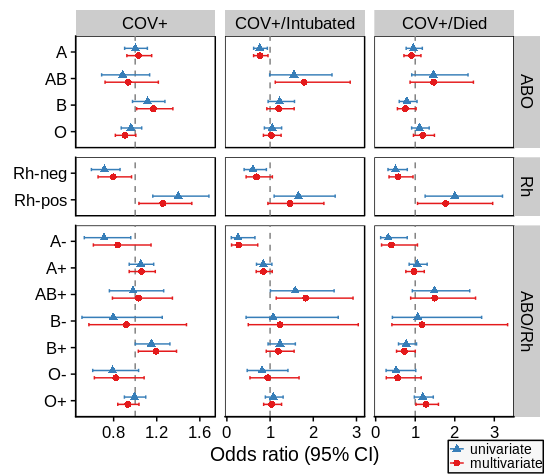

In [42]:
options(repr.plot.width = 5.5, repr.plot.height = 4.75, repr.plot.res = 100)

individual_blood_group_associations_plot

In [515]:
ggsave('../img/figure_1.png', individual_blood_group_associations_plot, width = 5.5, height = 4.75, dpi = 400)
ggsave('../img/figure_1.pdf', individual_blood_group_associations_plot, width = 5.5, height = 4.75)

### 4.4. Figure 2: Small forest plots

In [33]:
make_bg_forest <- function(bg) {
    pdf("NULL")
    
    meta_analysis_df %>% 
        filter(blood_group == bg) %>%
        pull(meta) %>%
        first %>%
        forest(
            leftcols = c('studlab'),
            leftlabs = c('Source'),
            smlab = "",
            rightcols = c("effect", "ci"),
            rightlabs = c("OR", "95% CI"),
            hetstat = F,
            overall.hetstat = F,
            backtransf = TRUE,
            plotwidth = "2cm",
            calcwidth.pooled = F,
            text.random = "Random effects",
            col.diamond.random = "red",
            squaresize = 0.5,
            addrow = F,
            colgap = "1mm"
        )
    grid.text(bg, x = 0.025, hjust = 0, y = 0.95, vjust = 1, 
              gp = gpar(cex = 1.5, fontface = "bold", fontfamily = "sans"))
    ret <- grid.grab()
    whatever <- dev.off()
    ret
}

all_forest_plots <- list("A", "AB", "B", "O") %>% map(make_bg_forest)

In [34]:
grid.newpage()
pdf("../img/figure_2.pdf", height = 4.75, width = 7)
grid.arrange(all_forest_plots[[1]], all_forest_plots[[2]], 
             all_forest_plots[[3]], all_forest_plots[[4]], 
             ncol = 2, nrow = 2)
dev.off()

grid.newpage()
png("../img/figure_2.png", height = 4.75, width = 7, units = "in", res = 400)
grid.arrange(all_forest_plots[[1]], all_forest_plots[[2]], 
             all_forest_plots[[3]], all_forest_plots[[4]], 
             ncol = 2, nrow = 2)
dev.off()

png 
  2

png 
  2

### 4.5. Supplementary Figure 1: larger meta-analysis plots

In [490]:
plot_forest <- function(bg) {
    pdf("NULL")
    meta_analysis_df %>% 
        filter(blood_group == bg) %>% 
        pull(meta) %>% 
        first %>%
        forest(
            JAMA.pval = T, 
            test.overall.random = T, 
            leftcols = c('studlab', 'event.e', 'n.e', 'event.c', 'n.c'),
            leftlabs = c('Source', 'COV+', 'Total', 'COV+', 'Total'),
            lab.e = str_c('ABO: ', bg),
            lab.c = str_c('ABO: ¬', bg),
            print.zval = F,
            smlab = "",
            plotwidth = "2cm",
            text.random = "Random effects",
            col.diamond.random = "red",
            squaresize = 0.5,
            addrow = F,
            colgap = "2mm"
        )
    
    grid.text(bg, x = 0.01, hjust = 0, 
              y = 0.975, vjust = 1, gp = gpar(cex = 2))
    ret <- grid.grab()
    whatever <- dev.off()
    ret
}

all_forest_plots <- list("A", "AB", "B", "O") %>% map(plot_forest)

In [493]:
grid.newpage()
pdf("../img/figure_2_supplementary.pdf", height = 9, width = 8)
grid.arrange(all_forest_plots[[1]], all_forest_plots[[2]], 
             all_forest_plots[[3]], all_forest_plots[[4]], 
             ncol = 1, nrow = 4)
dev.off()

grid.newpage()
png("../img/figure_2_supplementary.png", height = 9, width = 8, units = "in", res = 400)
grid.arrange(all_forest_plots[[1]], all_forest_plots[[2]], 
             all_forest_plots[[3]], all_forest_plots[[4]], 
             ncol = 1, nrow = 4)
dev.off()

png 
  2

png 
  2

### 4.6. Supplementary Table 2: Chi-squared tests for overall associations

In [37]:
st2_chisq <- chi_squared_df %>%
    mutate(
        p.value = p.value %>% formatC(., digits = 2, format = 'g', flag = '#'),
        blood_group_type = blood_group_type %>% 
            recode('abo' = 'ABO', 'abo_rh' = 'ABO/Rh', 'rh' = 'Rh'),
        across(c(group_1, group_2), ~str_replace_all(
            ., c('_neg' = '-', '_pos' = '+', 'neg' = 'Rh-neg', 'pos' = 'Rh-pos')))
    ) %>%
    select('Comparison' = test_id, 'Blood group type' = blood_group_type, 
           'Group 1 counts' = group_1, 'Group 2 counts' = group_2, 'p-value' = p.value)

### 4.7. Supplementary Table 3:  Individual blood group associations

In [72]:
st3_one_vs_rest <- individual_blood_group_associations_df %>%
    filter(term == 'had_blood_group', blood_group != 'AB_neg') %>%
    mutate(
        outcome = outcome %>% recode_factor(
            'cov_pos' = 'COV+', 'intubated' = 'COV+/Intubated', 'died' = 'COV+/Died'),
        blood_group = blood_group %>% 
            str_replace_all(c('_neg' = '-', '_pos' = '+', 'neg' = 'Rh-neg', 'pos' = 'Rh-pos')),
        conf.low = estimate - 1.96 * std.error,
        conf.high = estimate + 1.96 * std.error,
        across(c(estimate, conf.low, conf.high), ~sprintf('%.3f', exp(.))),
        p.value = p.value %>% sprintf('%.2g', .),
        ci = str_c(conf.low, conf.high, sep = '-'),
        formatted = str_glue('{estimate}, [{ci}], p={p.value}') %>% as.character
    ) %>%
    pivot_wider(id_cols = c(outcome, blood_group), 
                names_from = formula_id, values_from = formatted) %>%
    select('Outcome' = outcome, 'Blood group' = blood_group,
           'Raw estimate' = univariate, 'Adjusted estimate' = multivariate) 

### 4.8. Supplementary Table 4: Blood group ~ Risk factors

In [39]:
st4_bg_vs_rf <- bg_rf_df %>%
    filter(term != '(Intercept)') %>%
    mutate(
        blood_group = blood_group %>% 
            str_replace_all(c('_neg' = '-', '_pos' = '+', 'neg' = 'Rh-neg', 'pos' = 'Rh-pos')),
        
        term = term %>% 
            str_replace_all(c(
                'risk_factor_' = '', 'male_sex' = 'sex (male)', 'ethn_' = 'ethnicity ', 
                'race_' = 'race ', 'hs$' = '(Hispanic)', 'asian' = '(Asian)',
                'black_aa' = '(Black)', 'other' = '(Other)', 'missing' = '(Missing)',
                '_' = ' ', 'normed' = '')),
        
        conf.low = estimate - 1.96 * std.error,
        conf.high = estimate + 1.96 * std.error,
        across(c(estimate, conf.low, conf.high), ~sprintf('%.3f', exp(.))),
        p.value = p.value %>% sprintf('%.2g', .),
        ci = str_c(conf.low, conf.high, sep = '-')
    ) %>%
    select('Blood group' = blood_group, 'Term' = term, 'OR' = estimate, '95% CI' = ci, 'p-value' = p.value) 

### 4.9. Supplementary Table 5: Model fits

In [401]:
s5_model_fits <- model_fits_df %>%
    mutate(
        outcome = outcome %>% recode_factor(
            'cov_pos' = 'COV+', 'intubated' = 'COV+/Intubated', 'died' = 'COV+/Died'),
        across(c('Deviance', 'Resid. Dev'), ~round(., digits = 1)),
        'Pr(>Chi)' = `Pr(>Chi)` %>% sprintf('%.2g', .)
    ) %>%
    select('Outcome' = outcome, 'Comparison' = comparison_id, 'df' = Df, 
           'Resid. df' = 'Resid. Df', 'Deviance', 'Resid. deviance' = 'Resid. Dev',
           'p-value' = 'Pr(>Chi)')

### 4.10. Supplementary figure: Correlation matrix

In [43]:
options(repr.plot.width = 8, repr.plot.height = 6)

matrix_order <- c(
    'abo_A' = 'A',
    'abo_AB' = 'AB',
    'abo_B' = 'B',
    'abo_O' = 'O',
    'rh_neg' = 'Rh-neg',
    'age' = 'age',
    'male_sex' = 'sex (male)',
    'risk_factor_cardiovascular_disorders' = 'CV dis.',
    'risk_factor_diabetes_mellitus' = 'diabetes',
    'risk_factor_hypertension' = 'HTN',
    'risk_factor_obesity' = 'obesity',
    'risk_factor_respiratory_disorders' = 'resp. dis.'
) %>% rev

correlation_matrix <- regression_df %>% 
    recipes::recipe() %>%
    recipes::step_dummy(race, ethnicity, abo, rh, one_hot = T) %>%
    recipes::prep() %>%
    recipes::juice() %>%
    select(age, male_sex, starts_with('risk_factor_'),
           starts_with('abo_'), -abo_rh, rh_neg) %>%
    cor(method = 'pearson')

correlation_matrix <- correlation_matrix[names(matrix_order), names(matrix_order)]
correlation_matrix[upper.tri(correlation_matrix)] <- NA
correlation_matrix <- correlation_matrix %>%
    as.data.frame %>%
    rownames_to_column('var1') %>%
    mutate(var1 = var1 %>% fct_reorder(row_number())) %>%
    pivot_longer(-var1, names_to = 'var2') %>%
    drop_na %>%
    mutate(across(c(var1, var2), ~recode_factor(.x = ., !!!matrix_order)))


full_correlation_matrix_plot <- correlation_matrix %>%
    filter(!var2 %in% c('A', 'B', 'AB', 'O', 'Rh-neg'), var1 != var2) %>%
    ggplot(aes(x = fct_rev(var1), y = var2, fill = value)) +
    geom_tile() +
    scale_fill_distiller(name = 'Spearman\ncorrelation', palette = 'Blues', direction = 1, 
                         trans = 'pseudo_log', breaks = c(0, 0.25, 0.5, 0.75, 1)) +
    theme_void() +
    theme(
        axis.text.y = element_text(),
        axis.text.x = element_text(angle = 25, hjust = 1, vjust = 1),
        legend.position = c(0.93, 0.68)
    )

bg_only_correlation_plot <- correlation_matrix %>%
    filter(!var2 %in% c('A', 'B', 'AB', 'O', 'Rh-neg'), var1 %in% c('A', 'B', 'AB', 'O', 'Rh-neg')) %>%
    ggplot(aes(x = fct_rev(var1), y = var2, fill = value)) +
    geom_tile() +
    scale_fill_distiller(name = 'Spearman\ncorrelation', palette = 'Blues', direction = 1) +
    theme_void() +
    theme(
        axis.text.y = element_text(size = 9, hjust = 1),
        axis.text.x = element_text(size = 9, margin = margin(b = 1)),
    )

combined_plot <- plot_grid(
    full_correlation_matrix_plot + theme(plot.margin = margin(t = 0.5, r = 0.2, unit = 'cm')), 
    bg_only_correlation_plot + theme(plot.margin = margin(t = 0.51, b = 0.7, unit = 'cm')), 
    rel_widths = c(1, 0.65), 
    labels = c('A', 'B'), label_x = 0, label_y = 1.01
)

ggsave('../img/correlation_matrix.png', combined_plot, height = 3, width = 8, dpi = 400)
ggsave('../img/correlation_matrix.pdf', combined_plot, height = 3, width = 8)

In [46]:
correlation_matrix %>%
    filter(!var2 %in% c('A', 'B', 'AB', 'O', 'Rh-neg'), var1 != var2) %>%
    write_tsv('../data/spearman_correlation_matrix.tsv')

### 4.11. Race/ethnicity stratified analysis

In [54]:
race_stratified_plot_df <- race_stratified_bg_vs_rest %>%
    filter(
        term == 'had_blood_group', blood_group_type %in% c('abo', 'rh'), blood_group != 'pos',
        !race_ethnicity %in% c('race_asian', 'ethnicity_other'), blood_group != 'AB'
    ) %>%
    mutate(
        conf.low = estimate - 1.96 * std.error,
        conf.high = estimate + 1.96 * std.error,
        across(c(estimate, conf.low, conf.high), exp),
        outcome = outcome %>% recode_factor(
            'cov_pos' = 'COV+', 'intubated' = 'COV+/Intubated', 'died' = 'COV+/Died'),
        blood_group_type = blood_group_type %>% recode('abo' = 'ABO', 'rh' = 'Rh'),
        blood_group = blood_group %>% str_replace_all(c('abo_' = '', 'pos' = 'Rh-pos', 'neg' = 'Rh-neg')),
        blood_group_type = blood_group_type %>% fct_relevel(c('ABO', 'Rh')),
        race_ethnicity = race_ethnicity %>% str_replace_all(c('race_' = 'Race ', 'ethnicity_' = 'Ethnicity ',
                                                              'black_aa' = 'black/AA', 'nonhs' = 'non-Hispanic',
                                                              'hs' = 'Hispanic')) %>% fct_rev
    ) %>%
    select(-term, -std.error, -statistic) %>%
    relocate(c(conf.low, conf.high), .after = estimate)

In [55]:
race_ethnicity_stratified_plot <- race_stratified_plot_df %>%
    ggplot(aes(x = estimate, xmin = conf.low, xmax = conf.high, y = race_ethnicity,
               group = formula_id, shape = formula_id, color = formula_id)) +
    geom_vline(xintercept = 1, color = 'grey50', linetype = 'dashed') + 
    geom_errorbarh(height = 0.25, position = position_dodge(width = 0.55)) +
    geom_point(size = 2, position = position_dodge(width = 0.55)) +
    facet_grid(rows = vars(blood_group), cols = vars(outcome), scales = 'free') +
    theme_cowplot() +
    xlab('Odds ratio (95% CI)') +
    guides(color = guide_legend(reverse = T), shape = guide_legend(reverse = T)) +
    scale_color_brewer(palette = 'Set1') +
    theme(
        panel.background = element_rect(color = 'black'),
        axis.title.y = element_blank(),
        legend.title = element_blank()
    )

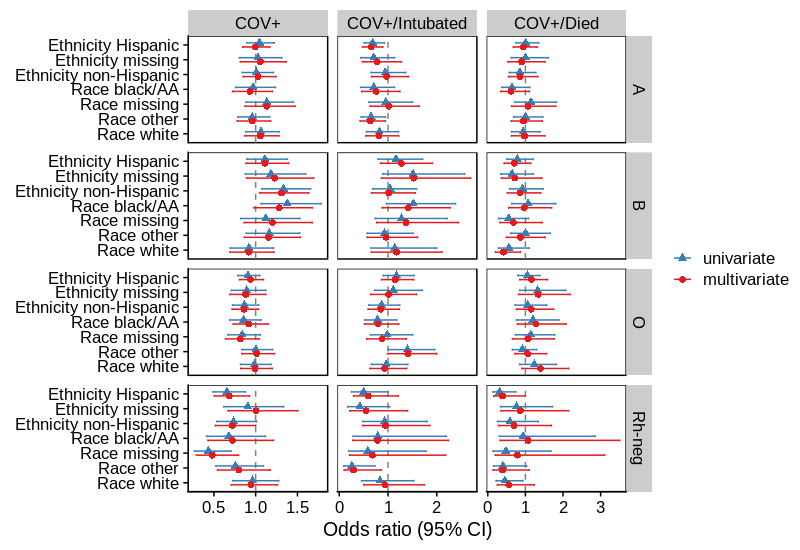

In [56]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)

race_ethnicity_stratified_plot

In [57]:
race_stratified_plot_df %>% write_tsv('../data/race_ethn_stratified_associations.tsv')

In [580]:
ggsave('../img/race_ethnicity_stratified.png', race_ethnicity_stratified_plot, height = 5.5, width = 8, dpi = 400)
ggsave('../img/race_ethnicity_stratified.pdf', race_ethnicity_stratified_plot, height = 5.5, width = 8)

## 5. Export analysis to Google Drive

#### Main text

1. Table 1 (both basic and stratified)
2. Table 2: Meta analysis
3. Figure 1: Effect size estimates
4. Figure 2: Small meta-analysis forest plots

#### Supplementary materials

1. Table 1: ABO/Rh stratified Table 1 
2. Table 2: Chi-squared tests
3. Table 3: One-vs-rest (uni/multi) regression coefficients
4. Table 4: Blood group - risk factor association regression coefficients
5. Table 5: Model fits ANOVA
6. Figure 1: Larger meta-analysis forest plots

In [58]:
library(googlesheets4)
gs4_auth(email = 'michael.zietz@gmail.com', path = '~/.ssh/xswap-compute-5b866b2d1e2f.json', 
         use_oob = TRUE)

library(googledrive)
drive_auth(email = 'michael.zietz@gmail.com', path = '~/.ssh/xswap-compute-5b866b2d1e2f.json')


Attaching package: ‘googledrive’

The following objects are masked from ‘package:googlesheets4’:

    request_generate, request_make



In [368]:
all_tables = list(
        # Main text tables
        't1_basic' = table_1_basic, 
        't1_stratified' = table_1_stratified, 
        't2_meta' = table_2_meta,

        # Supplementary tables
        'st1_aborh_stratified' = st1_abo_rh_table_1,
        'st2_chisq' = st2_chisq,
        'st3_one_vs_rest' = st3_one_vs_rest,
        'st4_bg_vs_rf' = st4_bg_vs_rf,
        'st4_bg_vs_rf_filtered' = st4_bg_vs_rf %>%
            filter(`Blood group` %in% c('A', 'B', 'AB', 'O'), as.numeric(`p-value`) < 0.05),
        'st5_model_fits' = s5_model_fits
    ) %>% 
    map(~mutate(.x, across(everything(), as.character)))

In [ ]:
sheet_name <- str_glue('analysis_{date}') %>% as.character
drive_rm(sheet_name)

abo_sheet <- gs4_create(
    name = sheet_name,
    sheets = all_tables
)

drive_mkdir(name = 'analysis_revised_v1.1', path = 'ABO_COVID/', overwrite = T)
drive_mv(file = sheet_name, path = 'ABO_COVID/analysis_revised_v1.1/', overwrite = T)

In [3]:
for (file in list.files(path = '../img/', pattern = '*', full.names = T)) {
    drive_put(file, path = 'ABO_COVID/analysis_revised_v1.1/')
}

Pre-existing file found at this filepath. Calling `drive_update()`.
File updated:
  * correlation_matrix.pdf: 1HFXBFDv_8paB0Da3F3JxZcWzLAvqSWOg
Pre-existing file found at this filepath. Calling `drive_update()`.
File updated:
  * correlation_matrix.png: 1g01JeTXCrKHyh1DI1gMPtvhr6bU-T1Sm
Pre-existing file found at this filepath. Calling `drive_update()`.
File updated:
  * figure_1.pdf: 1rBBLp4-XafJhVpAMHcaXLV_wrI06rADg
Pre-existing file found at this filepath. Calling `drive_update()`.
File updated:
  * figure_1.png: 1HqVxttnbm-5CjtW0veaS5EG4GaIJ1k9s
Pre-existing file found at this filepath. Calling `drive_update()`.
File updated:
  * figure_2_supplementary.pdf: 1qUQ-0kn0BN61IDeFCT-3e4-m8t0zu_Fs
Pre-existing file found at this filepath. Calling `drive_update()`.
File updated:
  * figure_2_supplementary.png: 1__FeMJJ3NryjhZ9nqZhZdq3kKSI9_v1t
Pre-existing file found at this filepath. Calling `drive_update()`.
File updated:
  * figure_2.pdf: 1TUwljyzjMQrpE0ZxD-C9uvmMM4CrxY1g
Pre-existing f

In [503]:
st4_bg_vs_rf %>%
    filter(!`Blood group` %in% c("AB-", "Rh-pos")) %>% 
    write_tsv('../data/2020-06-15/blood_group_risk_factor_associations.tsv')

In [59]:
for (file in c('../data/race_ethn_stratified_associations.tsv', '../data/spearman_correlation_matrix.tsv')) {
    drive_put(file, path = 'ABO_COVID/analysis_revised_v1.1/')
}

No pre-existing file at this filepath. Calling `drive_upload()`.
Local file:
  * ../data/race_ethn_stratified_associations.tsv
uploaded into Drive file:
  * race_ethn_stratified_associations.tsv: 1i9a6LdRZ3RIA7ZhTGeXI1oLQH9e1HTJ8
with MIME type:
  * text/tab-separated-values
No pre-existing file at this filepath. Calling `drive_upload()`.
Local file:
  * ../data/spearman_correlation_matrix.tsv
uploaded into Drive file:
  * spearman_correlation_matrix.tsv: 1VEfpW0lzLB1P9TU3KMeyUwsKPscEiNRQ
with MIME type:
  * text/tab-separated-values
